In [16]:
import numpy as np
import os
import pandas as pd
import json
from dscribe.descriptors import CoulombMatrix
from dscribe.descriptors import MBTR
from ase import Atoms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

font = {'size'   : 22}
matplotlib.rc('font', **font)
%matplotlib widget

In [17]:
# Import data
os.getcwd()
os.chdir(r"C:\Users\s201204.FRIDA\Documents\Materials Design with Machine Learning\KaggleCompetition")

from LoadData import train, test

# Import info about the nr of atoms in data
from LoadData import max_number_of_atoms, min_atomic_number, max_atomic_number, species, number_of_atoms, atomic_numbers

# Import fingerprint generator
from Fingerprints import Coulombmatrices
from Fingerprints import get_MBTR

# Import PCA
from PCA_decomposition import PCA_decomposition

In [18]:
species

['Te',
 'I',
 'Br',
 'V',
 'Pd',
 'Ir',
 'O',
 'Ag',
 'Pt',
 'C',
 'Y',
 'Cl',
 'Cu',
 'H',
 'Cd',
 'As',
 'Mo',
 'Sn',
 'Os',
 'B',
 'Nb',
 'Co',
 'Ti',
 'Ga',
 'Rh',
 'Se',
 'Ba',
 'P',
 'Ni',
 'Sr',
 'Re',
 'F',
 'Tl',
 'Mn',
 'Cs',
 'Rb',
 'Si',
 'Pb',
 'Zr',
 'Fe',
 'Ru',
 'Li',
 'Hf',
 'Al',
 'K',
 'Na',
 'Bi',
 'Sc',
 'Ca',
 'Sb',
 'Au',
 'Zn',
 'Be',
 'Ta',
 'S',
 'Mg',
 'In',
 'Ge',
 'W',
 'Hg',
 'Cr',
 'N']

In [19]:
train.head()

,id,formula,atoms,hform
0,5154,Zr2BO2,"(Atom('Zr', [np.float64(1.6878604657), np.floa...",-2.037877
1,984,Ni2S6,"(Atom('Ni', [np.float64(1.1571403137), np.floa...",-0.091020
2,1634,Cd4K2Cl6O6Te2,"(Atom('Cd', [np.float64(2.7840261751), np.floa...",-1.109751
3,1872,Hf4H2N3O2,"(Atom('Hf', [np.float64(0.0), np.float64(1.867...",-1.609142
4,2977,Sc2Te2,"(Atom('Te', [np.float64(0.0003850118), np.floa...",-0.854593


In [20]:
cmats = Coulombmatrices(train, max_number_of_atoms)

0
1000
2000
3000
4000
5000
6000
7000


In [21]:
# Set target and feature vector 
X = pd.DataFrame(data = cmats, index=train.id)
y = pd.DataFrame(train['hform'].values, index = train.id)
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (8000, 400)
y: (8000, 1)


In [22]:
# Split training data into a training set and a validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=251)
y_test_values = y_test.values  # Extract values as a NumPy array
y_train_values = y_train.values  # Extract values as a NumPy array

So far so good


In [23]:
# The question is if data is shuffled in the PCA. Chat says no.

In [24]:
class GP:
    def __init__(self, train, target, sigma):
        self.train = train
        self.target = target
        self.train_dist = cdist(train, train, metric='sqeuclidean')
        self.target_mean = np.mean(target)
        self.target_normalized = target - self.target_mean
        self.N = len(train)
        self.sigma = sigma

    def kernel(self, x1, x2, ll, k0):
        diff = x1 - x2
        return k0 * np.exp(-np.sum(diff ** 2, axis=-1) / (2 * ll ** 2))
    
    def train_GP(self, ll, k0):
        self.ll = ll
        self.k0 = k0
        K = k0 * np.exp(- self.train_dist / (2 * ll ** 2))
        C = K + k0 * self.sigma ** 2 * np.identity(self.N)
        L = np.linalg.cholesky(C)  # Cholesky decomposition for stability
        self.Cinvt = np.linalg.solve(L.T, np.linalg.solve(L, self.target_normalized))

    def predict(self, fingerprint):
        diff = fingerprint - self.train
        kvec = self.k0 * np.exp(-np.sum(diff ** 2, axis=1) / (2 * self.ll ** 2))
        prediction = np.dot(kvec, self.Cinvt) + self.target_mean
        return prediction


In [25]:
n_PC = 130

# Standardize the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA to the training set
pca = PCA(n_components=n_PC)  # Reduce to 3 components
X_train_pca = pca.fit_transform(X_train_scaled)

# Now apply the same transformations to the test set
X_test_scaled = scaler.transform(X_test)  # Use the same scaler
X_test_pca = pca.transform(X_test_scaled)  # Use the same PCA


In [26]:
simpleGP = GP(X_train_pca, y_train_values, sigma = 0.003)

In [27]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse

In [28]:
k = 1
l=0.04
simpleGP.train_GP(l, k)
predictions = np.array([simpleGP.predict(fingerprint) for fingerprint in X_test_pca])
print(f"With l = {l} RMSE = {rmse(y_test_values, predictions)}")


With l = 0.04 RMSE = 0.6784856142244645


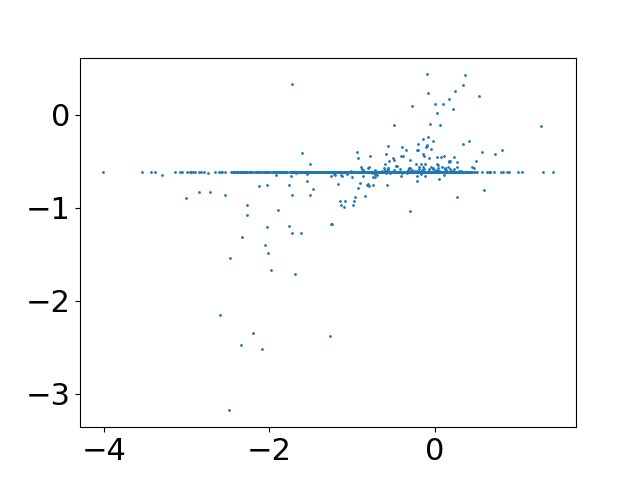

In [29]:
plt.figure()
plt.scatter(y_test_values, predictions, s = 1)